In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [23]:
file = open('insurance.csv', 'r')
reader = csv.reader(file)
data = []

for row in reader:
	data.append(row)
print(data.pop(0))
data = np.array(data)

data[:, 1][data[:, 1] == 'male'] = 0
data[:, 1][data[:, 1] == 'female'] = 1
data[:, 4][data[:, 4] == 'no'] = 0
data[:, 4][data[:, 4] == 'yes'] = 1
data[:, 5][data[:, 5] == 'northeast'] = 0
data[:, 5][data[:, 5] == 'northwest'] = 1
data[:, 5][data[:, 5] == 'southeast'] = 2
data[:, 5][data[:, 5] == 'southwest'] = 3
data = data.astype(np.float64)

split_idx = int(len(data)*0.8)


#normalize data
for i in range(len(data[0])):
	std = np.std(data[:,i])
	data[:,i] = data[:,i] - np.mean(data[:,i])
	data[:,i] = data[:,i]/std

x_data_train = np.zeros((split_idx, 3))
x_data_train[:,0] = data[:split_idx, 0]
x_data_train[:,1] = data[:split_idx, 2]
x_data_train[:,2] = data[:split_idx, 3]
#x_data = data[:, :6].reshape((len(data), 6, 1))
y_data_train = data[:split_idx, 6]
print(x_data_train.shape)
print(x_data_train.shape)

x_data_test = np.zeros((len(data) - split_idx, 3))
x_data_test[:,0] = data[split_idx:, 0]
x_data_test[:,1] = data[split_idx:, 2]
x_data_test[:,2] = data[split_idx:, 3]
#x_data = data[:, :6].reshape((len(data), 6, 1))
y_data_test = data[split_idx:, 6]
print(x_data_test.shape)
print(x_data_test.shape)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
(1070, 3)
(1070, 3)
(268, 3)
(268, 3)


In [26]:
# N = len(data)
# alpha = 2.3
# sigma = 2.
# slope = 4.
# x = np.random.normal (size=N)
# y = alpha + slope * x + sigma * np.random.normal(size=N)

data = {
	'N': len(x_data_train),
	'K': len(x_data_train[0]),
    'x': x_data_train,
    'y': y_data_train
}

In [27]:
program_code = """
data {
  int<lower=1> N;           // Number of samples
  int<lower=1> K;           // Number of predictors
  matrix[N, K] x;              // Covariate
  vector[N] y;              // Outcome
}

parameters {
  real alpha;               // Intercept
  row_vector[3] beta;       // Slope
  real<lower=0> sigma;      // Noise
}

model {
  // Priors
  sigma ~ inv_gamma(1, 1);     //tau0 = 1, tau1 = 1
  alpha ~ normal(0, 10);       //sigma_alhpa = 10
  beta ~ multi_normal(rep_vector(0, 3), diag_matrix(rep_vector(10, 3)));  //sigma_beta = 10

  // Likelihood
  for (n in 2:N)
    y[n] ~ normal(alpha + beta * x[n]', sigma);
}
"""

In [28]:
model = stan.build(program_code,data)
fit = model.sample(num_chains=3,num_warmup=1000,num_samples=2500)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/10500)
Sampling:   1% (101/10500)
Sampling:   2% (201/10500)
Sampling:   5% (500/10500)
Sampling:   7% (700/10500)
Sampling:  10% (1000/10500)
Sampling:  12% (1300/10500)
Sampling:  15% (1600/10500)
Sampling:  17% (1800/10500)
Sampling:  20% (2100/10500)
Sampling:  23% (2400/10500)
Sampling:  50% (5300/10500)
Sampling:  75% (7900/10500)
Sampling: 100% (10500/10500)
Sampling: 100% (10500/10500), done.
Messages received during sampling:
  Gradient evaluation took 0.000735 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001157 seconds
  1000 transitions using 10 leapfrog steps per transition would take 11.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000267 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.67 seconds.
  Adjust your expectations accordi

In [29]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,beta.3,sigma
draws,,,,,,,,,,,,
0,-584.910451,0.989488,0.744699,3.0,7.0,0.0,588.949972,0.005057,0.266045,0.159937,0.082840,0.934584
1,-585.588439,0.863361,0.821769,2.0,3.0,0.0,586.857361,0.016126,0.287704,0.206374,0.052017,0.943042
2,-585.506814,1.000000,0.689787,3.0,7.0,0.0,586.298749,0.024227,0.263901,0.192030,0.058735,0.954507
3,-584.524540,0.998787,0.744699,3.0,7.0,0.0,585.268048,0.009647,0.289754,0.170578,0.035654,0.939181
4,-584.446638,1.000000,0.821769,2.0,3.0,0.0,585.711268,0.004309,0.277000,0.180975,0.048180,0.948938


In [30]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.026,-0.049,0.047,0.0,0.0,9883.0,5795.0,1.0
beta[0],0.279,0.026,0.228,0.328,0.0,0.0,9529.0,5632.0,1.0
beta[1],0.168,0.026,0.122,0.219,0.0,0.0,9943.0,5517.0,1.0
beta[2],0.055,0.026,0.006,0.102,0.0,0.0,8808.0,6063.0,1.0
sigma,0.940,0.018,0.906,0.974,0.0,0.0,8291.0,5851.0,1.0


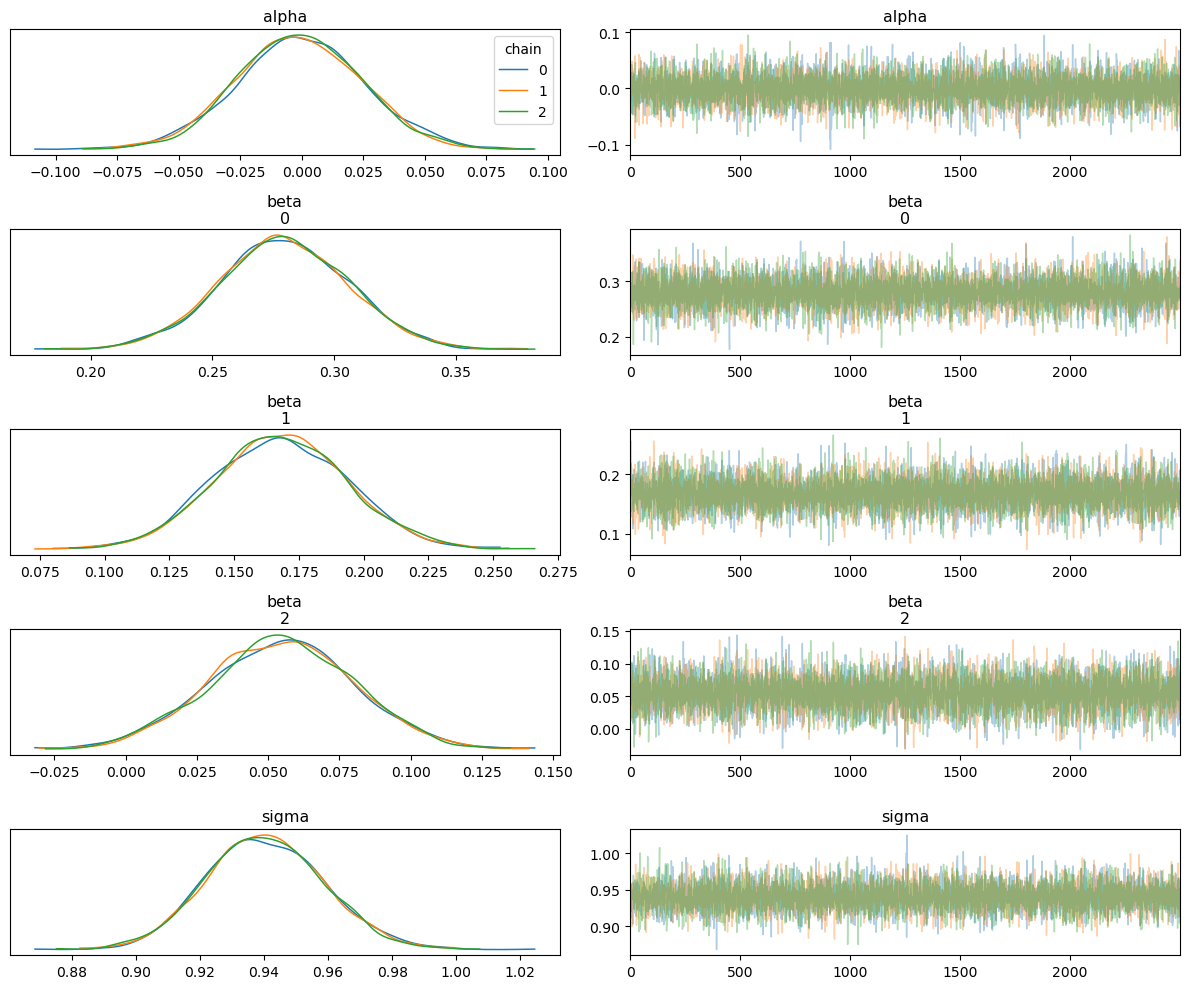

In [31]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()